## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler
from skorch.helper import predefined_split
from skorch.dataset import Dataset

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.models.Ensembles import DeepEnsemble
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *
from src.utils.loss_metric_utils import DiagNLLLoss, MAPELoss, RMSELoss, BetaNLL

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


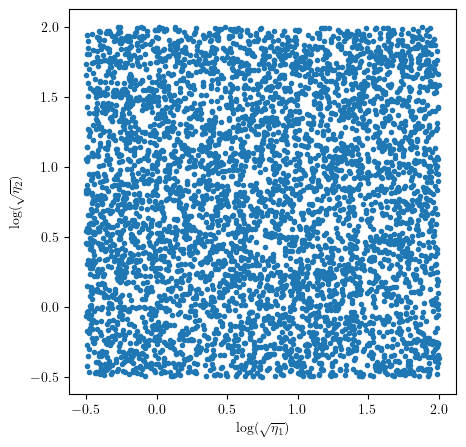

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = True
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All", noise_type='none', d_condition=">=", noise=0.5, num_samples=1)

etas_test, gs_test = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [3]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32)

## Network Training

In [8]:
# Defining model parameters
chkpt_prefix = 'Regular_Resid_5k'
chkpt_dir = '../Model_Checkpoints/Ensemble/Resid_Hetero_5k/' + chkpt_prefix + '/'


net_params = {
    "input_dim": 2,
    "output_dim": 3,
    "num_layers": 4,
    "h_dim": 20,
    "out_noise": "heteroscedastic"
}

train_params = {
    "criterion": BetaNLL,  # MSELoss, DiagNLLLoss
    "criterion__beta": 0.0,
    "optimizer": torch.optim.Adam,
    "optimizer__weight_decay": 1e-5,
    "lr": 0.001,
    "batch_size": 64,
    "max_epochs": 500,
    "device": device,
    "iterator_train__shuffle": True,
    "iterator_train__pin_memory": True,
    "train_split": predefined_split(Dataset(x_test, y_test)),
    "verbose": 0,
}

def create_ensemble_mem(i):
    net_name = chkpt_prefix + f'_Ens_{i}.pt'

    callbacks = [EarlyStopping(patience=15, threshold=0.001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
            Checkpoint(monitor='valid_loss_best', f_params=net_name, dirname=chkpt_dir),
            LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.00001, threshold_mode='abs', mode='min')
        ]
    train_params['callbacks'] = callbacks

    return create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)

num_members = 40

In [9]:
DE = DeepEnsemble(create_ensemble_mem, num_members)

DE = DE.fit(x_train, y_train)

Predictor 1 trained
Predictor 2 trained
Predictor 3 trained
Predictor 4 trained
Predictor 5 trained
Predictor 6 trained
Predictor 7 trained
Predictor 8 trained
Predictor 9 trained
Predictor 10 trained
Predictor 11 trained
Predictor 12 trained
Predictor 13 trained
Predictor 14 trained
Predictor 15 trained
Predictor 16 trained
Predictor 17 trained
Predictor 18 trained
Predictor 19 trained
Predictor 20 trained
Predictor 21 trained
Predictor 22 trained
Predictor 23 trained
Predictor 24 trained
Predictor 25 trained
Predictor 26 trained
Predictor 27 trained
Predictor 28 trained
Predictor 29 trained
Predictor 30 trained
Predictor 31 trained
Predictor 32 trained
Predictor 33 trained
Predictor 34 trained
Predictor 35 trained
Predictor 36 trained
Predictor 37 trained
Predictor 38 trained
Predictor 39 trained
Predictor 40 trained


## Reloading Ensemble

In [10]:
chkpt_prefix = 'Regular_Resid_5k'
dir_name = "Resid_Hetero_5k"
chkpt_dir = '../Model_Checkpoints/Ensemble/' + dir_name + '/' + chkpt_prefix + '/'
data_dir = '../data/Ensemble/' + dir_name + '/'

DE = DeepEnsemble(create_ensemble_mem, num_members)
DE = DE.load(reinitialize_model, lambda i: chkpt_dir + chkpt_prefix + f'_Ens_{i}.pt')

40 Predictor(s) loaded


## Generating Statistics Data

RMSE:  0.004594725689415983
MAE:  0.0009849749686870824


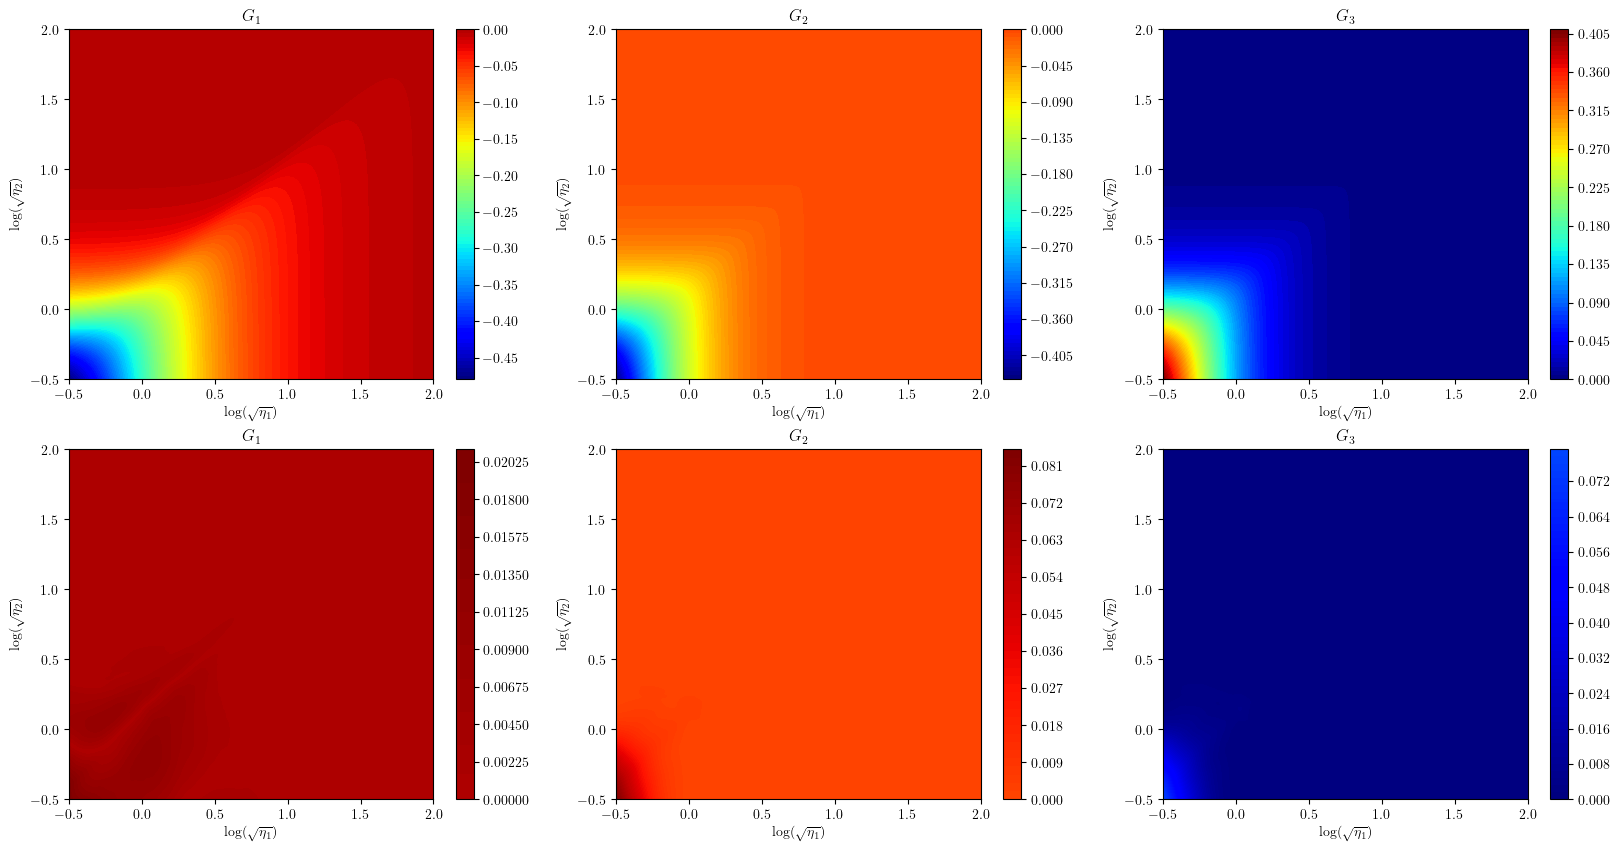

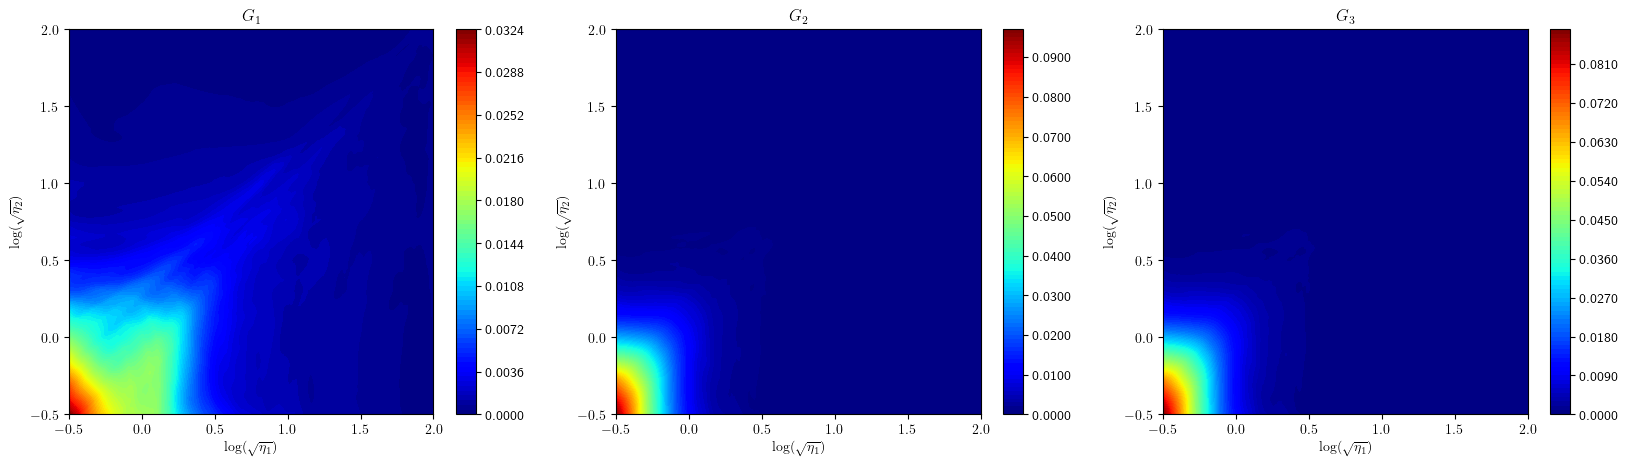

In [11]:
test_criteria = RMSELoss()
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

preds = np.zeros((num_members, len(etas), 3))
if 'out_noise' in net_params and net_params['out_noise'] == 'homoscedastic':
    stds = np.zeros((num_members, 3))
elif 'out_noise' in net_params and net_params['out_noise'] == 'heteroscedastic':
    stds = np.zeros((num_members, len(etas), 3))

for i in range(DE.n_predictors):
    if 'out_noise' in net_params and net_params['out_noise'] == 'homoscedastic':
        out = DE.predictors[i].predict(etas.astype(np.float32))
        stds[i] = DE.predictors[i].module_.sigma.detach().cpu().numpy() * y_scaler.scale_  # scale the std by the scaler's scale
        preds[i] = y_scaler.inverse_transform(out)
    elif 'out_noise' in net_params and net_params['out_noise'] == 'heteroscedastic':
        out, std = DE.predictors[i].forward(torch.tensor(etas, dtype=torch.float32))
        stds[i] = std.detach().cpu().numpy()
        preds[i] = y_scaler.inverse_transform(out.detach().cpu().numpy())
    else:
        preds[i] = y_scaler.inverse_transform(DE.predictors[i].predict(etas.astype(np.float32)))
    

pred_mean = preds.mean(axis=0)

std = preds.std(axis=0)

if 'out_noise' in net_params and net_params['out_noise'] == 'homoscedastic':
    alea_std = stds.mean(axis=0) * y_scaler.scale_  # scale the std by the scaler's scale
    print("Ensemble noise std: ", alea_std)
    std = np.sqrt(std**2 + alea_std**2)
    np.savetxt(data_dir + chkpt_prefix + '_Sigmas.csv', alea_std, delimiter=',')
elif 'out_noise' in net_params and net_params['out_noise'] == 'heteroscedastic':
    obs_std = np.sqrt((stds * y_scaler.scale_**2).mean(axis=0))
    std = np.sqrt(std**2 + obs_std**2)
    np.savetxt(data_dir + chkpt_prefix + '_Obs_Noise.csv', obs_std, delimiter=',')

np.savetxt(data_dir + chkpt_prefix + '_Pred_Mean.csv', pred_mean, delimiter=',')
np.savetxt(data_dir + chkpt_prefix + '_Pred_Std.csv', std, delimiter=',')

rmse = test_criteria(torch.tensor(target), torch.tensor(pred_mean).T.reshape(3, dim, dim)).item()

print("RMSE: ", rmse)
print("MAE: ", np.mean(np.abs(target - pred_mean.T.reshape(3, dim, dim))))

plot_heat_map_compare(x_grid, y_grid, target, np.abs(target - pred_mean.T.reshape(3, dim, dim)), 'Algebraic', 'Ensemble', sup_title=False)

plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim), "Ensemble Standard Deviation", sup_title=False)

Ensemble Obs Noise: [0.0050169  0.0049899  0.00501793]
Mean as Prediction
Mean of (mean - y): [-2.31736506e-05  6.97460447e-05 -1.50714907e-06]
Mean std of (mean - y): [0.00048211 0.00041018 0.00038028]
Samples as Predictors
Mean Residual: [-2.31736506e-05  6.97460447e-05 -1.50714907e-06]
Std of Preds: [0.00082994 0.00056831 0.00053756]
Sharpness: [0.00045955 0.00037966 0.00035761]
Individual Predictors
Mean Residual of Predictors: [-2.31736506e-05  6.97460447e-05 -1.50714907e-06]
Std of Residuals [0.00105826 0.00079193 0.00074478] 


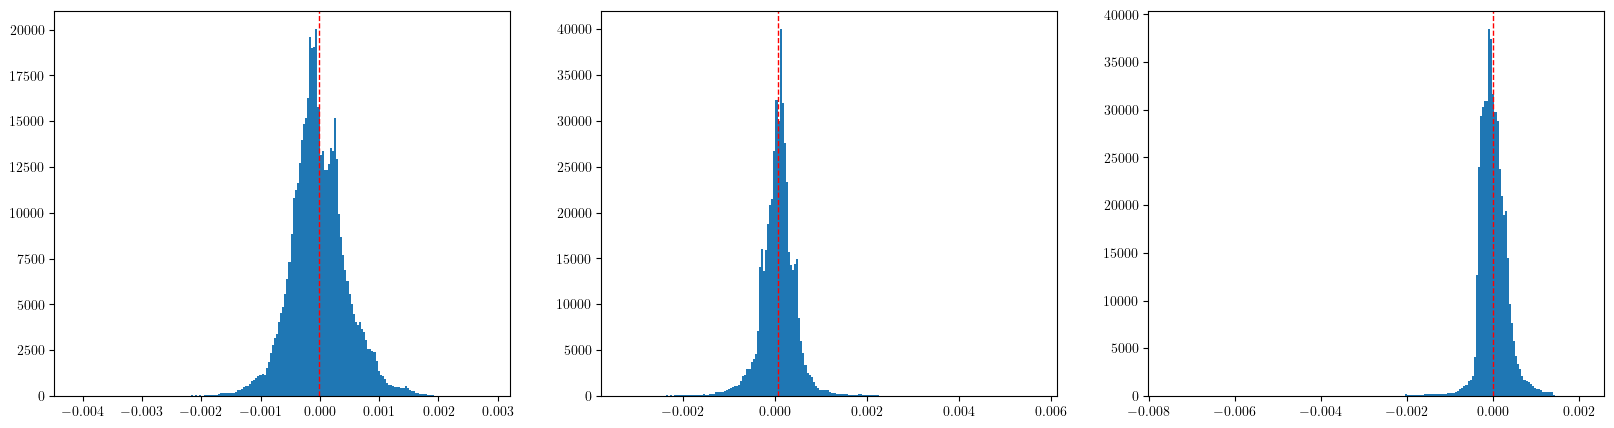

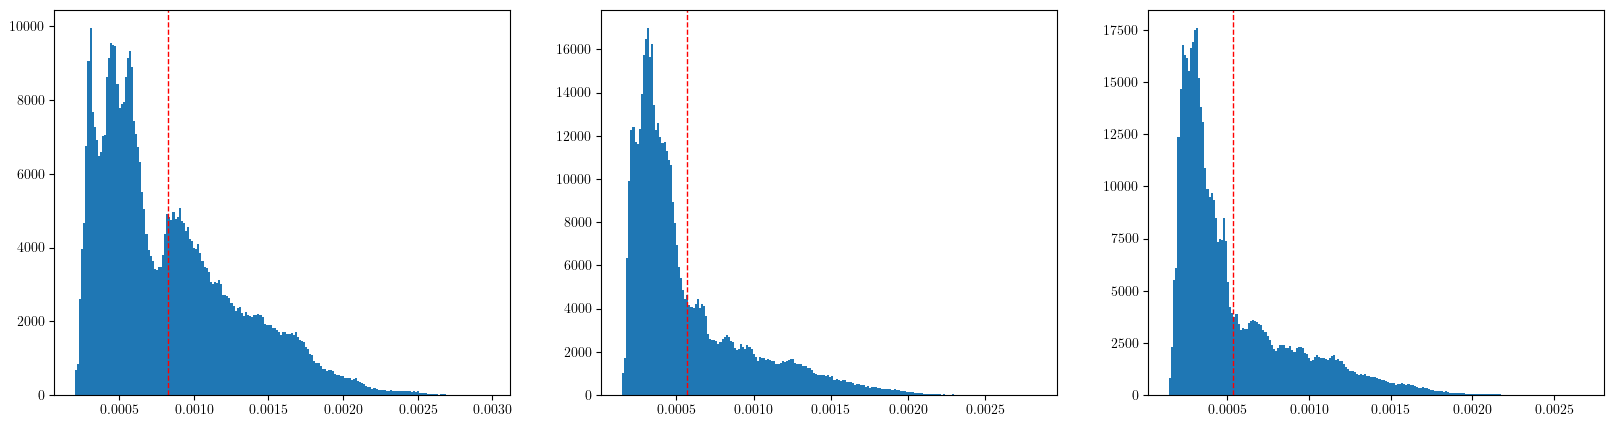

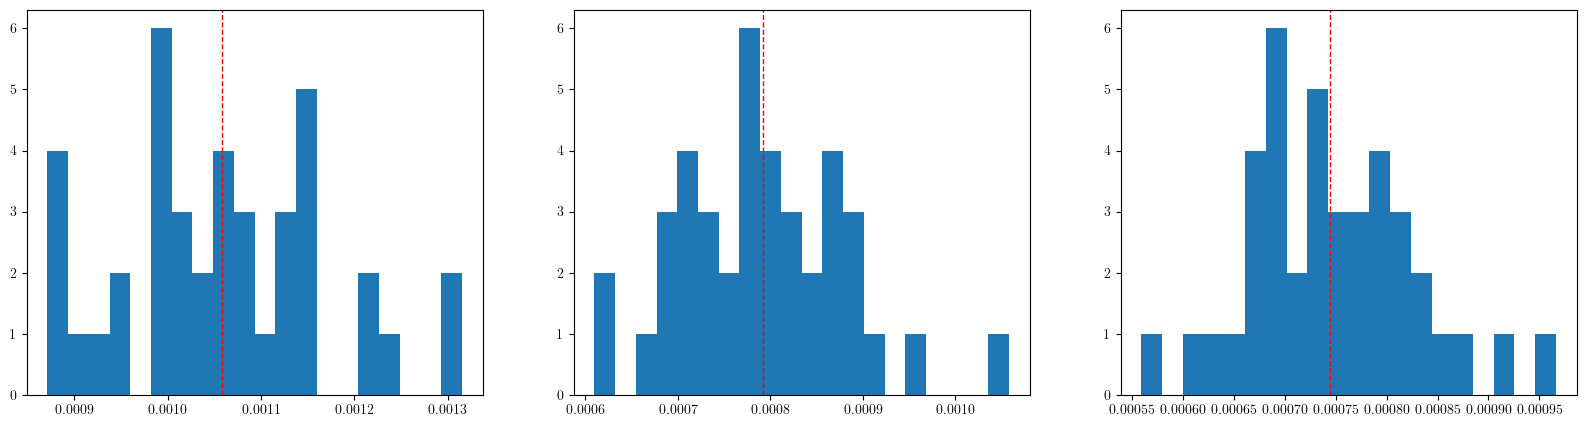

In [82]:
mean_resid = pred_mean - target.reshape(3, -1).transpose(1,0)
resid = preds - target.reshape(3, -1).transpose(1,0)

pred_std = np.std(preds, axis=0)
resid_std = np.std(resid, axis=0)
resid_mean = np.mean(resid, axis=0)
mean_resid_std = np.std(mean_resid, axis=0)
pred_resid_std = np.std(resid, axis=1)

print(f"Ensemble Obs Noise: {alea_std}")
print(f"Mean as Prediction")
print(f"Mean of (mean - y): {np.mean(mean_resid, axis=0)}")
print(f"Mean std of (mean - y): {mean_resid_std}")

print(f"Samples as Predictors")
print(f"Mean Residual: {np.mean(resid, axis=(0,1))}")
print(f"Std of Preds: {np.mean(pred_std, axis=0)}")
print(f"Sharpness: {np.std(resid_std, axis=0)}")

print(f"Individual Predictors")
print(f"Mean Residual of Predictors: {np.mean(resid_mean, axis=0)}")
print(f"Std of Residuals {np.std(resid, axis=1).mean(0)} ")

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(mean_resid[:, 0], bins=200)
ax[1].hist(mean_resid[:, 1], bins=200)
ax[2].hist(mean_resid[:, 2], bins=200)

ax[0].axvline(mean_resid[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(mean_resid[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(mean_resid[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(resid_std[:, 0], bins=200)
ax[1].hist(resid_std[:, 1], bins=200)
ax[2].hist(resid_std[:, 2], bins=200)

ax[0].axvline(resid_std[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(resid_std[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(resid_std[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(pred_resid_std[:, 0], bins=20)
ax[1].hist(pred_resid_std[:, 1], bins=20)
ax[2].hist(pred_resid_std[:, 2], bins=20)
ax[0].axvline(pred_resid_std[:, 0].mean(), color='r', linestyle='dashed', linewidth=1)
ax[1].axvline(pred_resid_std[:, 1].mean(), color='r', linestyle='dashed', linewidth=1)
ax[2].axvline(pred_resid_std[:, 2].mean(), color='r', linestyle='dashed', linewidth=1)

plt.show()

In [83]:
preds_train = np.zeros((num_members, len(etas_train), 3))
stds_train = np.zeros((num_members, 3))

for i in range(DE.n_predictors):
    out = DE.predictors[i].predict(x_train.detach().numpy().astype(np.float32))
    preds_train[i] = y_scaler.inverse_transform(out)
    if 'out_noise' in net_params and net_params['out_noise']:
        stds_train[i] = DE.predictors[i].module_.sigma.detach().cpu().numpy()

resid = preds_train - gs_train

resid_mem_std = np.std(resid, axis=1)

print(f"Predicted std: {alea_std}")
print(f"Ensemble Residuals Std: {resid_mem_std.mean(0)}")

Predicted std: [0.0050169  0.0049899  0.00501793]
Ensemble Residuals Std: [0.00501562 0.0049878  0.00501566]
